<a href="https://colab.research.google.com/github/arvind-22/Colab_Projects/blob/main/Speech_Emotion_Recognition_with_librosa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

In [ ]:
!pip install PyAudio

In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

Define a function extract_feature to extract the mfcc, chroma, and mel features from a sound file. This function takes 4 parameters- the file name and three Boolean parameters for the three features:

* mfcc: Mel Frequency Cepstral Coefficient, represents the short-term power 
spectrum of a sound
* chroma: Pertains to the 12 different pitch classes
* mel: Mel Spectrogram Frequency

Open the sound file with soundfile.SoundFile using with-as so it’s automatically closed once we’re done. Read from it and call it X. Also, get the sample rate. If chroma is True, get the Short-Time Fourier Transform of X.

In [ ]:
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

Now, let’s define a dictionary to hold numbers and the emotions available in the RAVDESS dataset, and a list to hold those we want- calm, happy, fearful, disgust.

In [ ]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

* Using our emotions dictionary, this number is turned into an emotion, and our function checks whether this emotion is in our list of **observed_emotions**; if not, it continues to the next file. 
* It makes a call to extract_feature and stores what is returned in ‘feature’. 
* Then, it appends the feature to x and the emotion to y. So, the list x holds the features and y holds the emotions. 
* We call the function train_test_split with these, the test size, and a random state value, and return that.

In [ ]:
#Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)   

In [ ]:
#Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

In [ ]:
print((x_train.shape[0], x_test.shape[0]))

(576, 192)


In [ ]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


 Now, let’s initialize an **MLPClassifier**. This is a Multi-layer Perceptron Classifier; it optimizes the log-loss function using LBFGS or stochastic gradient descent. Unlike SVM or Naive Bayes, the MLPClassifier has an internal neural network for the purpose of classification. This is a feedforward **ANN model**.

In [ ]:
#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
#Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [ ]:
#Predict for the test set
y_pred=model.predict(x_test)

In [ ]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 68.75%


**PART 2**

In [25]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [33]:
# Paths for data.
from google.colab import drive
drive.mount('/content/drive')
Ravdess = "/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,disgust,/content/drive/MyDrive/speech-emotion-recognit...
1,happy,/content/drive/MyDrive/speech-emotion-recognit...
2,angry,/content/drive/MyDrive/speech-emotion-recognit...
3,calm,/content/drive/MyDrive/speech-emotion-recognit...
4,neutral,/content/drive/MyDrive/speech-emotion-recognit...


In [35]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,disgust,/content/drive/MyDrive/speech-emotion-recognit...
1,happy,/content/drive/MyDrive/speech-emotion-recognit...
2,angry,/content/drive/MyDrive/speech-emotion-recognit...
3,calm,/content/drive/MyDrive/speech-emotion-recognit...
4,neutral,/content/drive/MyDrive/speech-emotion-recognit...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


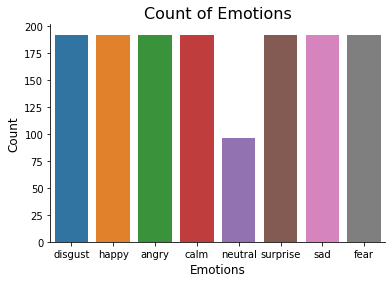

In [36]:
# Data Visualisation and Exploration
# First let's plot the count of each emotions in our dataset.
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [37]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

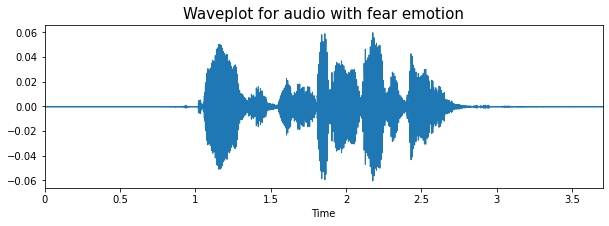

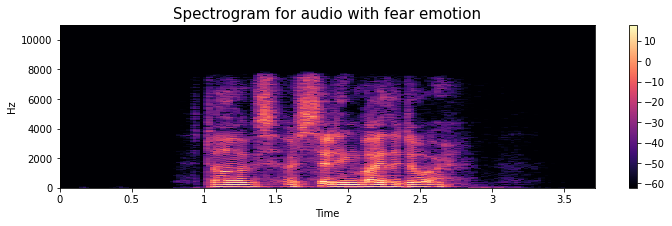

In [38]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

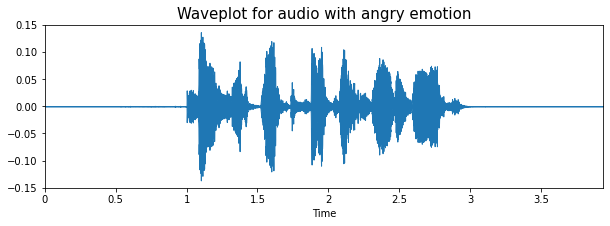

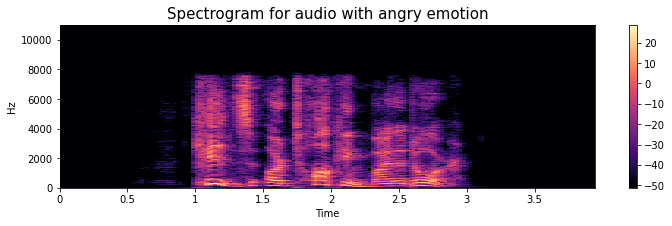

In [39]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

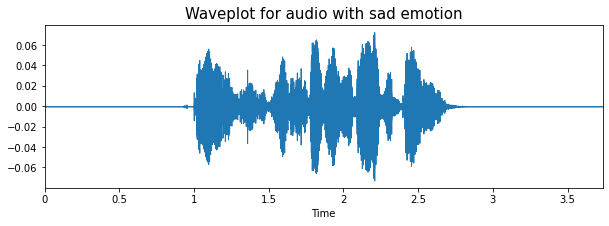

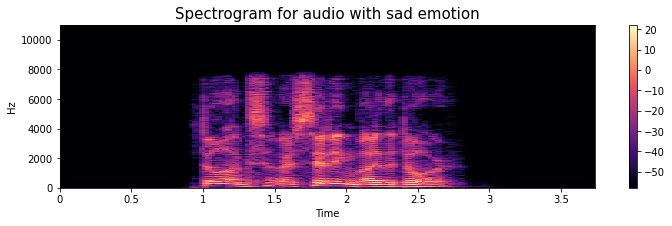

In [40]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

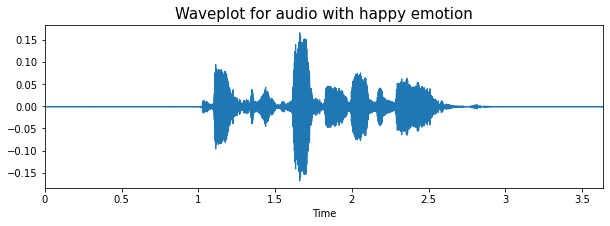

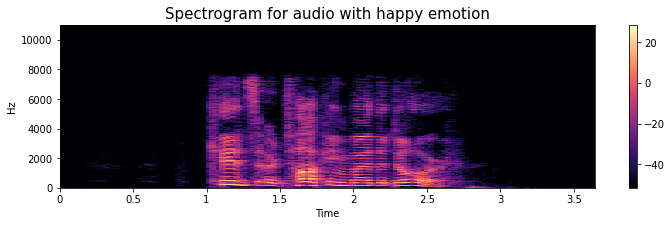

In [41]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

Data Augmentation

* Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
* To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
* The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
* In order to this to work adding the perturbations must conserve the same label as the original training sample.
* In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [42]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

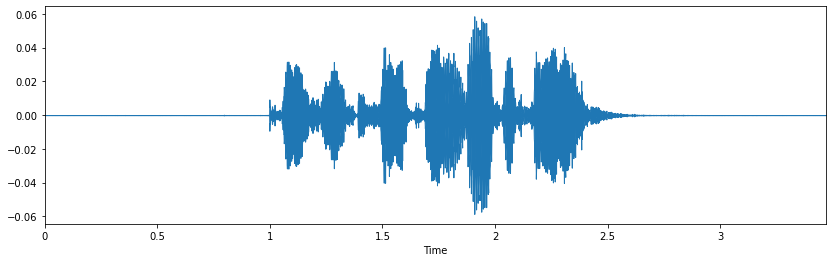

In [44]:
#Simple Audio
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

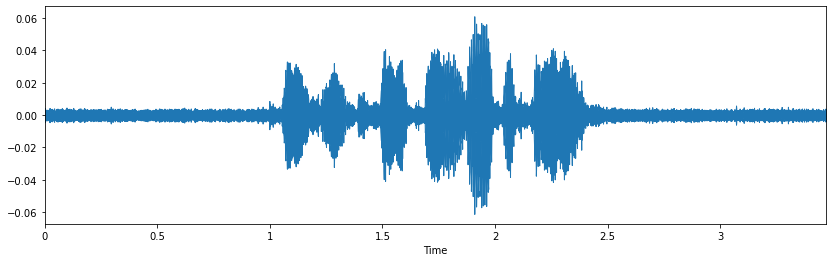

In [45]:
# Noise Inhection
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

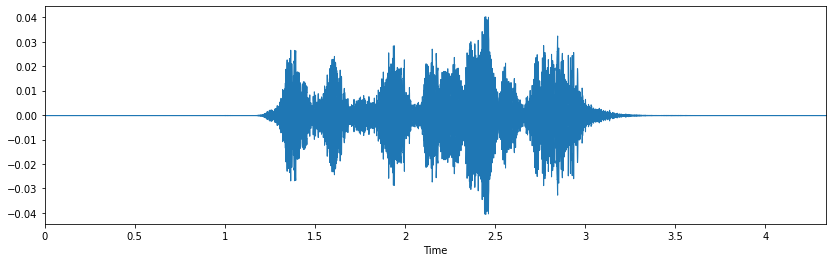

In [46]:
#Stretching
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

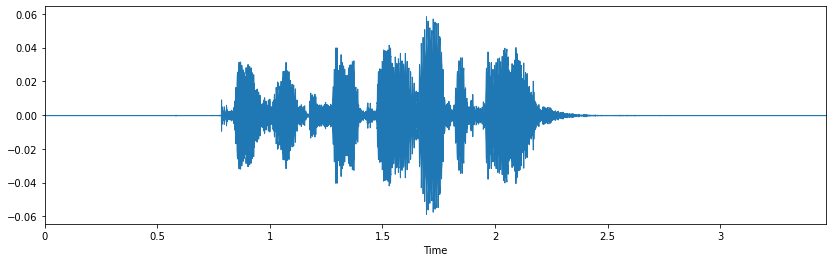

In [47]:
#Shifting
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

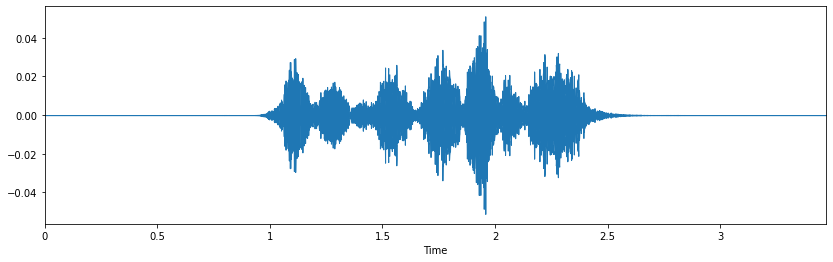

In [48]:
#Pitch
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Feature Extraction

* Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.
* The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

For Feature Extraction we are using the 5 features:

* Zero Crossing Rate
* Chroma_stft
* MFCC
* RMS(root mean square) value
* MelSpectogram to train our model.

In [49]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [50]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result


In [51]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [52]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [53]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.185443,0.616218,0.598484,0.623773,0.649101,0.657965,0.657408,0.663106,0.676516,0.653848,...,7.126472e-14,5.102435e-14,3.880021e-14,3.096563e-14,2.572642e-14,2.217541e-14,1.976906e-14,1.821246e-14,1.734345e-14,disgust
1,0.249299,0.693744,0.707660,0.699384,0.731125,0.740995,0.688441,0.630059,0.655013,0.654696,...,2.977671e-05,2.996707e-05,2.912139e-05,2.835396e-05,2.875953e-05,2.853491e-05,2.876958e-05,2.840746e-05,2.765727e-05,disgust
2,0.168432,0.555456,0.611558,0.587605,0.608950,0.663256,0.605385,0.622093,0.622120,0.661915,...,7.295001e-12,4.966073e-12,3.580724e-12,4.056608e-12,4.071608e-12,3.261495e-12,2.511722e-12,3.513613e-12,3.155195e-12,disgust
3,0.216684,0.645892,0.694382,0.686465,0.669116,0.708986,0.720299,0.641503,0.663535,0.709668,...,2.698463e-16,2.661278e-16,2.815288e-16,2.817272e-16,2.649162e-16,2.778407e-16,2.686326e-16,2.423029e-16,2.547290e-16,happy
4,0.288543,0.819350,0.811031,0.790671,0.816110,0.798867,0.652051,0.634630,0.683914,0.723939,...,1.525260e-04,1.509914e-04,1.443255e-04,1.418912e-04,1.508322e-04,1.456179e-04,1.452086e-04,1.504904e-04,1.502273e-04,happy


**Data Preparation**

As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [54]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [55]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [56]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [57]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [58]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

**Modelling**

In [59]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [60]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 30s 558ms/step - loss: 1.9886 - accuracy: 0.1861 - val_loss: 1.9386 - val_accuracy: 0.2417 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 30s 597ms/step - loss: 1.9261 - accuracy: 0.2299 - val_loss: 1.8866 - val_accuracy: 0.2528 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 33s 656ms/step - loss: 1.8499 - accuracy: 0.2525 - val_loss: 1.8015 - val_accuracy: 0.3102 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 33s 657ms/step - loss: 1.7885 - accuracy: 0.2904 - val_loss: 1.7620 - val_accuracy: 0.3278 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 25s 487ms/step - loss: 1.7607 - accuracy: 0.2997 - val_loss: 1.7170 - val_accuracy: 0.3398 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 23s 461ms/step - loss: 1.7066 - accuracy: 0.3272 - val_loss: 1.6811 - val_accuracy: 0.3713 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 23s 455ms/st

34/34 [==============================] - 2s 46ms/step - loss: 1.3827 - accuracy: 0.6296
Accuracy of our model on test data :  62.962961196899414 %


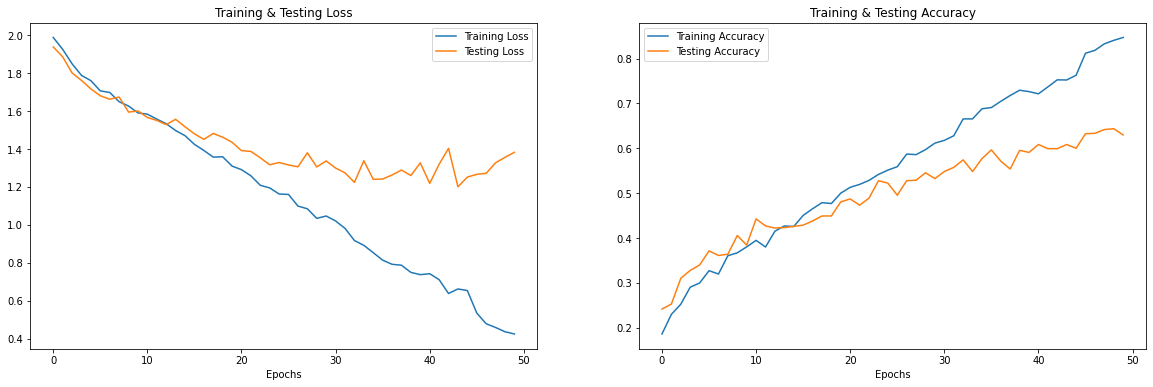

In [68]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [69]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [70]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,surprise,surprise
1,calm,calm
2,disgust,happy
3,calm,calm
4,happy,disgust
5,fear,fear
6,surprise,fear
7,sad,sad
8,disgust,sad
9,calm,calm


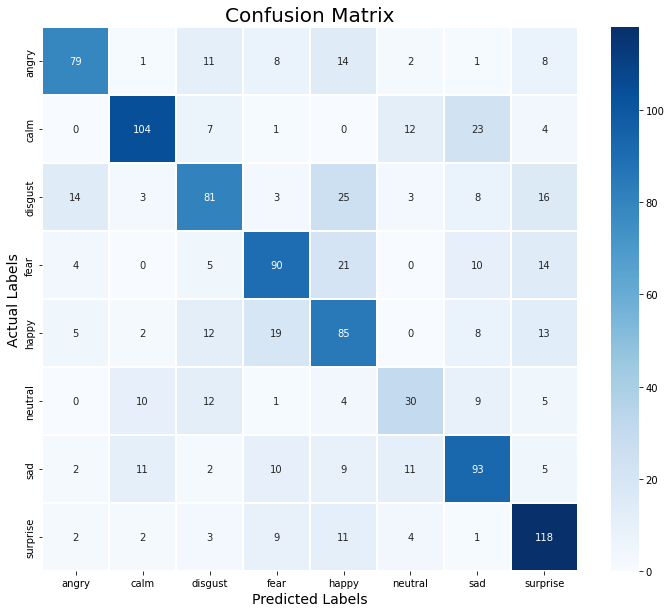

In [71]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.75      0.64      0.69       124
        calm       0.78      0.69      0.73       151
     disgust       0.61      0.53      0.57       153
        fear       0.64      0.62      0.63       144
       happy       0.50      0.59      0.54       144
     neutral       0.48      0.42      0.45        71
         sad       0.61      0.65      0.63       143
    surprise       0.64      0.79      0.71       150

    accuracy                           0.63      1080
   macro avg       0.63      0.62      0.62      1080
weighted avg       0.64      0.63      0.63      1080



* We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
* We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.